Standard imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

sns.set();

# DNN architecture

In [2]:
def DNN_predict(X_test,y_test,n_hidden_layers,n_hidden,name_file):

    tf.reset_default_graph()
    n_inputs = 6
    n_output = 1

    dropout_rate = 0
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
    y = tf.placeholder(tf.float32, shape = (None), name = "y")

    hidden_list = []
    hidden_drop_list = []
   
    with tf.name_scope("dnn"):
        for i,nhidden in enumerate(n_hidden):
            if i == 0:
                input_tensor = X 
            else:
                input_tensor = hidden_drop_list[i-1]
            name = "hidden{}".format(i)
            hidden_list.append(tf.layers.dense(input_tensor, nhidden, name = name, activation = tf.nn.relu))
            name = "hidden{}_drop".format(i)
            input_tensor = hidden_list[i]
            hidden_drop_list.append(tf.layers.dropout(input_tensor, dropout_rate, training=False))
        name = "outputs"    
        outputs = tf.layers.dense(hidden_drop_list[n_hidden_layers-1], n_output, name = name)

    error = outputs-y
    mse = tf.reduce_mean(tf.square(error),name="mse")
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
  
    print("DNN_parameters/{}_model.ckpt".format(name_file))

    with tf.Session() as sess:
        saver.restore(sess,"DNN_parameters/{}_model.ckpt".format(name_file))
    
        print("result",(mse.eval(feed_dict={X: np.c_[np.ones((X_test.shape[0],1)),X_test], y: y_test}))**0.5)
        y_predicted = outputs.eval(feed_dict={X: np.c_[np.ones((X_test.shape[0],1)),X_test]})
            
        return y_predicted

The file Mcrit_test.dat should contain the parameters for which we need to compute the critical mass. The columns are a/AU, T/K, P/cgs, L/cgs, Mcore/mearth. The last column contains the envelop mass (Earth mass) for plotting purpose.

In [3]:
test = np.loadtxt('Menve_lowkappa.dat')
X = np.float32(test[:,:5])
y = np.float32(test[:,5]).reshape(-1,1)
X_test = np.vstack([np.log10(X[:,0]),np.log10(X[:,1]),np.log10(X[:,2]),np.log10(X[:,3]),np.log10(X[:,4])]).T
y_test = np.log10(y)

In [4]:
from sklearn.preprocessing import StandardScaler

#instanciation of the scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()
data_scaler = np.loadtxt('scalers_Menve_lowkappa.dat')
scaler_X.mean_ = data_scaler[:5]
scaler_X.scale_ = data_scaler[5:10]
scaler_y.mean_ = data_scaler[10]
scaler_y.scale_ = data_scaler[11]
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [5]:
n_hidden_layers = 5
n_hidden = [128, 128, 128, 128, 128]
y_predicted = DNN_predict(X_test_scaled,y_test_scaled,n_hidden_layers,n_hidden,name_file="DNN_Menve_lowkappa")
y_predicted_unscaled = scaler_y.inverse_transform(y_predicted)

DNN_parameters/DNN_Menve_lowkappa_model.ckpt
INFO:tensorflow:Restoring parameters from DNN_parameters/DNN_Menve_lowkappa_model.ckpt
result 0.0210767771785


## y_predicted_unscaled contains the predicted envelop masses (in Earth masses)

(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.]),
 <a list of 7 Text yticklabel objects>)

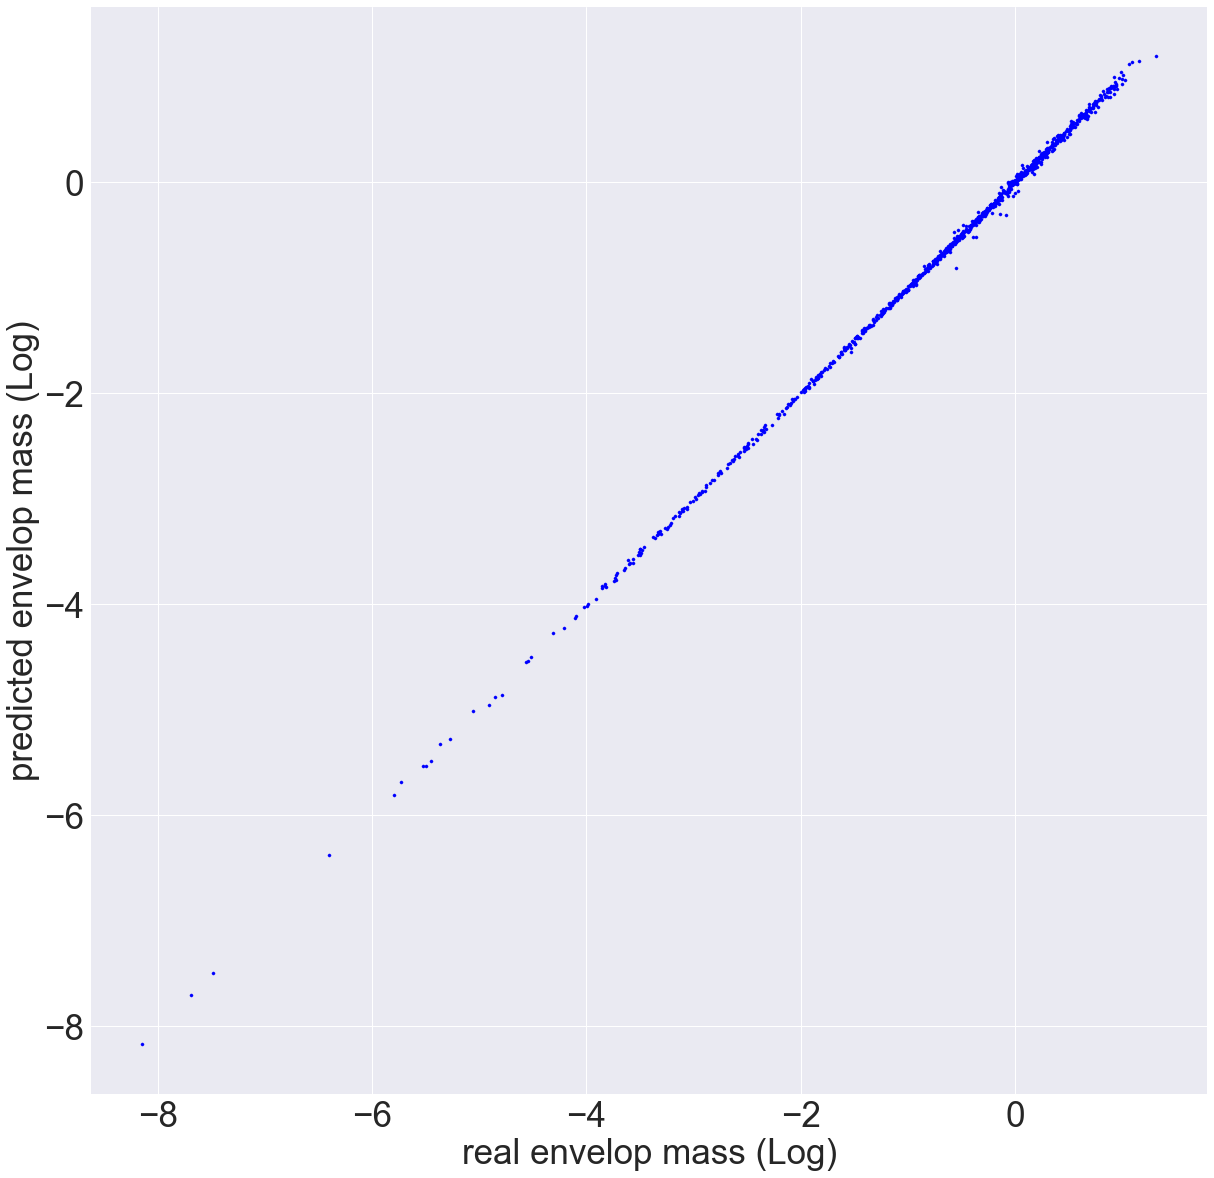

In [6]:
plt.rcParams['grid.linewidth'] = 1
plt.figure(figsize=(20,20))
plt.scatter(y_test,y_predicted_unscaled,s=10,alpha=1,c='blue')
plt.xlabel('real envelop mass (Log)',fontsize=35)
plt.ylabel('predicted envelop mass (Log)',fontsize=35);
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)